# ImageCAS dataset EDA

## 1. Check data

In [1]:
import autorootcwd
import os
import nibabel as nib
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
base_path = "data/imageCAS_ablation/train"

### Check data location and Count data

In [3]:
def check_missing_files(base_path):
    directories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    total_dirs = len(directories)
    
    print(f"\nTotal patient directory count: {total_dirs}")

    missing_patients = []
    
    for dir_name in tqdm(directories, desc="Checking missing files"):
        dir_path = os.path.join(base_path, dir_name)
        img_exists = os.path.exists(os.path.join(dir_path, 'img.nii.gz'))
        label_exists = os.path.exists(os.path.join(dir_path, 'label.nii.gz'))
        heart_combined_exists = os.path.exists(os.path.join(dir_path, 'heart_combined.nii.gz'))
        distance_map_exists = os.path.exists(os.path.join(dir_path, 'distance_map.nii.gz'))
        
        if not (img_exists and label_exists and heart_combined_exists and distance_map_exists):
            missing_files = []
            if not img_exists: missing_files.append('img.nii.gz')
            if not label_exists: missing_files.append('label.nii.gz')
            if not heart_combined_exists: missing_files.append('heart_combined.nii.gz')
            if not distance_map_exists: missing_files.append('distance_map.nii.gz')
            missing_patients.append((dir_name, missing_files))
    
    if missing_patients:
        print("\nPatients with missing files:")
        for patient_id, missing_files in missing_patients:
            print(f"Patient {patient_id}: {', '.join(missing_files)} missing")
    else:
        print("\nAll patient data have img.nii.gz, label.nii.gz, heart_combined.nii.gz, and distance_map.nii.gz files.")

check_missing_files(base_path)


Total patient directory count: 210


Checking missing files: 100%|██████████| 210/210 [00:00<00:00, 10098.88it/s]


All patient data have img.nii.gz, label.nii.gz, heart_combined.nii.gz, and distance_map.nii.gz files.


## Transforms in Proposed Dataloader

In [4]:
import autorootcwd
from monai.utils import first, set_determinism
from monai.transforms import (
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandFlipd,
    CropForegroundd,
    Compose,
    Spacingd,
    AsDiscreted,
    GaussianSmoothd,
    Lambda,
)
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import SimpleITK as sitk
import os
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import random

c:\2025 KIST\coronary-artery-ablation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
use_distance_map = True
random.seed(42)

### Before Clipping

In [6]:
def analyze_distance_map(distance_map):
    print("\nAnalyze Distance Map Result:")
    print(f"Shape: {distance_map.shape}")
    print("-" * 60)
    print(f"{'Channel':^8} | {'Min':^10} | {'Max':^10} | {'Mean':^10} | {'Std':^10}")
    print("-" * 60)
    
    for c in range(distance_map.shape[1]):
        channel_map = distance_map[0][c]
        
        print(f"{c:^8} | "
              f"{channel_map.min().item():^10.4f} | "
              f"{channel_map.max().item():^10.4f} | "
              f"{channel_map.mean().item():^10.4f} | "
              f"{channel_map.std().item():^10.4f}")
    
    print("-" * 60)

In [7]:
def create_distance_map(binary_mask):
    distance_maps = []
    
    for c in range(binary_mask.shape[0]):  # each channel
        channel_mask = binary_mask[c].numpy()  # [H, W, D]
        
        # convert to SimpleITK image
        sitk_mask = sitk.GetImageFromArray(channel_mask)
        sitk_mask = sitk.Cast(sitk_mask, sitk.sitkUInt8)
        
        # create distance map
        distance_map = sitk.SignedMaurerDistanceMap(
            sitk_mask,
            insideIsPositive=False,  # heart outside is positive
            squaredDistance=False,
            useImageSpacing=True     # physical distance (mm)
        )
        
        # convert to tensor
        distance_map_array = sitk.GetArrayFromImage(distance_map)
        distance_maps.append(torch.from_numpy(distance_map_array))
    
    return torch.stack(distance_maps)

def ConvertDistanceMap(data):
    seg = data["seg"]  # [C, H, W, D] one-hot encoded segmentation
    
    distance_map = create_distance_map(seg)
    
    data["seg"] = distance_map
    return data

In [8]:
transforms = [
    LoadImaged(keys=["image", "label", "seg", "dist"]),
    EnsureChannelFirstd(keys=["image", "label", "seg", "dist"]),
    Orientationd(keys=["image", "label", "seg", "dist"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg", "dist"], source_key="image"),
]

# distance map 
if use_distance_map:
    transforms.append(Lambda(ConvertDistanceMap))

transforms.extend([
    RandCropByPosNegLabeld(
        keys=["image", "label", "seg", "dist"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    RandFlipd(
        keys=["image", "label", "seg", "dist"],
        spatial_axis=[0],
        prob=0.10,
    ),
    RandFlipd(
        keys=["image", "label", "seg", "dist"],
        spatial_axis=[1],
        prob=0.10,
    ),
])

if not use_distance_map:
    transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

transforms.append(RandShiftIntensityd(keys="image", offsets=0.05, prob=0.5))

val_transforms = [
    LoadImaged(keys=["image", "label", "seg", "dist"]),
    EnsureChannelFirstd(keys=["image", "label", "seg", "dist"]),
    Orientationd(keys=["image", "label", "seg", "dist"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg", "dist"], source_key="image"),
]

# distance map
if use_distance_map:
    val_transforms.append(Lambda(ConvertDistanceMap))

if not use_distance_map:
    val_transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

val_transforms = Compose(val_transforms)

train_transforms = Compose(transforms)
val_transforms = Compose(val_transforms)

c:\2025 KIST\coronary-artery-ablation\.venv\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [9]:
def visualize_transforms(image_path, label_path, seg_path, dist_path, slice_idx=80, transform=train_transforms):
    """visualize the before/after transforms for a specific image."""
    
    data_dict = [{"image": image_path, "label": label_path, "seg": seg_path, "dist": dist_path}]
    
    basic_transforms = Compose([
        LoadImaged(keys=["image", "label", "seg", "dist"]),
        EnsureChannelFirstd(keys=["image", "label", "seg", "dist"]),
    ])
    
    basic_ds = Dataset(data=data_dict, transform=basic_transforms)
    full_ds = Dataset(data=data_dict, transform=transform)
    
    basic_data = first(DataLoader(basic_ds, batch_size=1))
    full_data = first(DataLoader(full_ds, batch_size=1))
    
    plt.figure("Transforms Visualization", (20, 15))
    
    # Original Data (First Row)
    plt.subplot(2, 4, 1)
    plt.title("Original Image")
    plt.imshow(basic_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    plt.subplot(2, 4, 2)
    plt.title("Original Label")
    plt.imshow(basic_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 4, 3)
    plt.title("Original Segmentation")
    plt.imshow(basic_data["seg"][0, 0, :, :, slice_idx])

    plt.subplot(2, 4, 4)
    plt.title("Original Distance Map")
    plt.imshow(basic_data["dist"][0, 0, :, :, slice_idx])
    
    # Transformed Data (Second Row)
    plt.subplot(2, 4, 5)
    plt.title("Transformed Image")
    plt.imshow(full_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    plt.subplot(2, 4, 6)
    plt.title("Transformed Label")
    plt.imshow(full_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 4, 7)
    plt.title("Transformed Segmentation")
    plt.imshow(full_data["seg"][0, 0, :, :, slice_idx])

    plt.subplot(2, 4, 8)
    plt.title("Transformed Distance Map")
    plt.imshow(full_data["dist"][0, 0, :, :, slice_idx])

    plt.tight_layout()
    plt.show()

    analyze_distance_map(full_data["seg"])
    analyze_distance_map(full_data["dist"])

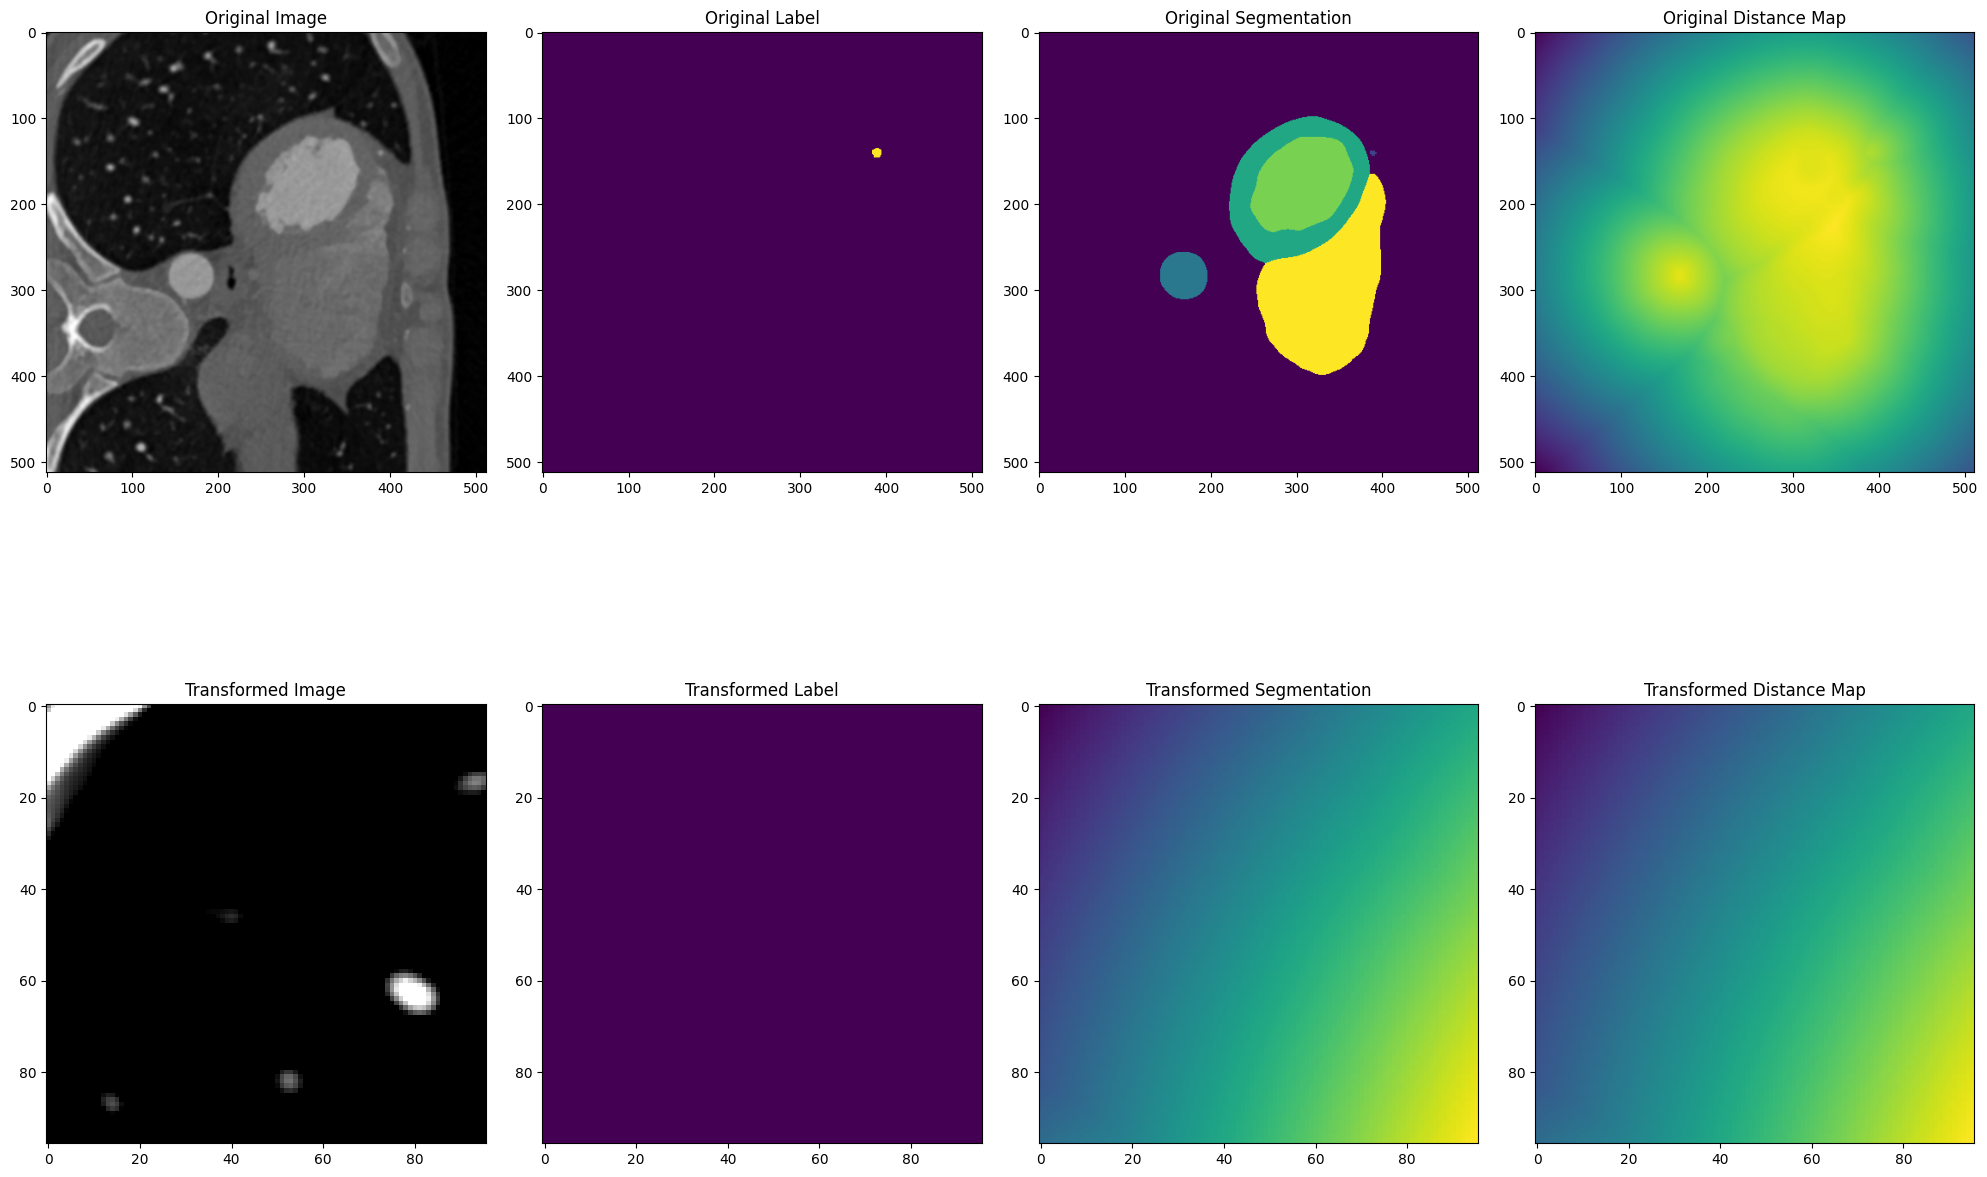


Analyze Distance Map Result:
Shape: torch.Size([4, 8, 96, 96, 96])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
------------------------------------------------------------
   0     | -239.4535  |  -82.8613  | -162.8061  |  27.4520  
   1     |  112.5567  |  274.8727  |  196.7004  |  27.5446  
   2     |  120.9173  |  266.1466  |  193.1327  |  27.6784  
   3     |  84.4334   |  241.1245  |  164.6046  |  27.5869  
   4     |  109.1925  |  261.1379  |  186.3885  |  27.5034  
   5     |  195.1820  |  340.7360  |  267.4155  |  27.5911  
   6     |  156.5280  |  321.0389  |  241.7347  |  27.6178  
   7     |  227.5104  |  381.4617  |  305.5506  |  27.6281  
------------------------------------------------------------

Analyze Distance Map Result:
Shape: torch.Size([4, 8, 96, 96, 96])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
----------

In [10]:
case_dir = "data/imageCAS_ablation/test/790"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")
seg_path = os.path.join(case_dir, "heart_combined.nii.gz")
dist_path = os.path.join(case_dir, "distance_map.nii.gz")

visualize_transforms(image_path, label_path, seg_path, dist_path, slice_idx=80, transform=train_transforms)

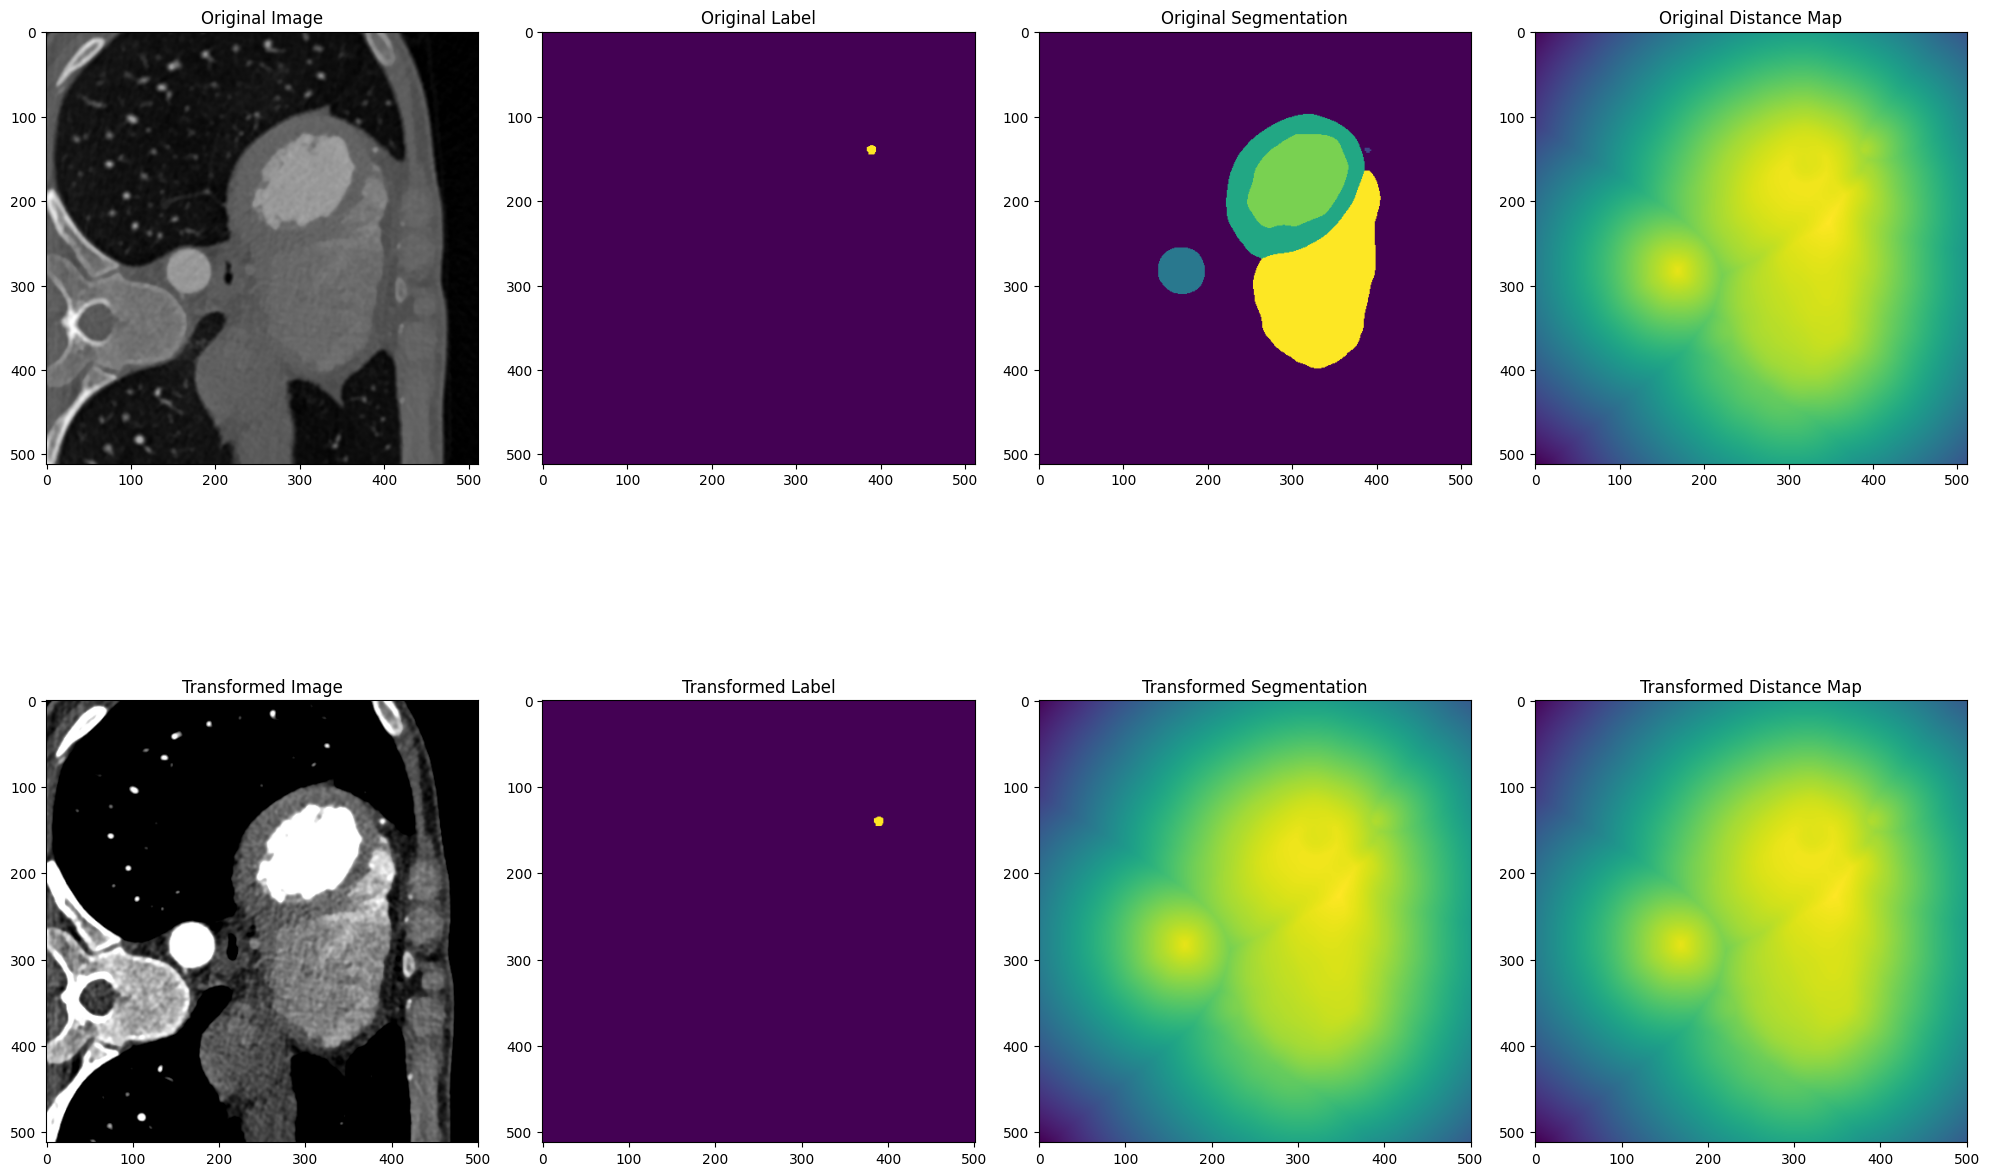


Analyze Distance Map Result:
Shape: torch.Size([1, 8, 512, 501, 275])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
------------------------------------------------------------
   0     | -276.0580  |  82.7345   |  -69.2250  |  61.8576  
   1     |  -2.8284   |  329.1595  |  115.2145  |  58.5534  
   2     |  -32.4962  |  384.6310  |  143.4577  |  71.9734  
   3     |  -15.6205  |  335.6665  |  116.7874  |  69.0712  
   4     |  -62.8729  |  360.1028  |  133.4326  |  73.3065  
   5     |  -52.0192  |  386.0117  |  129.4066  |  84.1378  
   6     |  -37.5366  |  397.0730  |  164.7632  |  72.6675  
   7     |  -41.6293  |  424.7964  |  173.2838  |  92.7978  
------------------------------------------------------------

Analyze Distance Map Result:
Shape: torch.Size([1, 8, 512, 501, 275])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
----

In [11]:
case_dir = "data/imageCAS_ablation/test/790"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")
seg_path = os.path.join(case_dir, "heart_combined.nii.gz")
dist_path = os.path.join(case_dir, "distance_map.nii.gz")   

visualize_transforms(image_path, label_path, seg_path, dist_path, slice_idx=80, transform=val_transforms)

### Clipping and Normalization

In [24]:
clip_value = 30.0

In [42]:
def analyze_label_distance_coverage(heart_seg, label):
    results = []
    
    for c in range(heart_seg.shape[0]):
        # Create distance map for heart segmentation
        sitk_mask = sitk.GetImageFromArray(heart_seg[c].numpy())
        sitk_mask = sitk.Cast(sitk_mask, sitk.sitkUInt8)
        
        distance_map = sitk.SignedMaurerDistanceMap(
            sitk_mask,
            insideIsPositive=False,
            squaredDistance=False,
            useImageSpacing=True
        )
        
        distance_map_array = sitk.GetArrayFromImage(distance_map)
        
        # Extract distance values at label positions
        label_points = label.numpy() > 0
        distances_at_labels = distance_map_array[label_points]
        
        # Percentage of label points within the clipping range
        within_range = np.logical_and(
            distances_at_labels >= -clip_value,
            distances_at_labels <= clip_value
        )
        coverage_percent = np.mean(within_range) * 100
        
        channel_result = {
            'channel': c,
            'min_dist': np.min(distances_at_labels),
            'max_dist': np.max(distances_at_labels),
            'mean_dist': np.mean(distances_at_labels),
            'median_dist': np.median(distances_at_labels),
            'coverage_percent': coverage_percent,
            'out_of_range_count': np.sum(~within_range),
            'total_label_points': len(distances_at_labels)
        }
        results.append(channel_result)
    
    print(f"\nLabel Points Distance Statistics (Clipping Range: {-clip_value}~{clip_value} mm)")
    print("-" * 90)
    print(f"{'Channel':^8} | {'Min(mm)':^10} | {'Max(mm)':^10} | {'Mean(mm)':^10} | {'Median(mm)':^10} | {'Coverage(%)':^13} | {'OutOfRange':^10}")
    print("-" * 90)
    
    for result in results:
        print(f"{result['channel']:^8} | "
              f"{result['min_dist']:^10.2f} | "
              f"{result['max_dist']:^10.2f} | "
              f"{result['mean_dist']:^10.2f} | "
              f"{result['median_dist']:^10.2f} | "
              f"{result['coverage_percent']:^13.2f} | "
              f"{result['out_of_range_count']:^10}")
    
    print("-" * 90)
    return results

In [48]:
def ProcessDistanceMap(data, clip_min=None, clip_max=None, normalize=False, norm_min=-1, norm_max=1):
    dist = data["dist"]  # [8, H, W, D]
    
    # clipping and normalization
    distance_maps = []
    
    for c in range(dist.shape[0]):  # each channel
        channel_dist = dist[c]  # [H, W, D]
        
        # clipping if clip_min and clip_max are provided
        if clip_min is not None and clip_max is not None:
            clipped_dist = torch.clamp(channel_dist, min=clip_min, max=clip_max)
        else:
            clipped_dist = channel_dist
        
        # normalize if normalize=True
        if normalize:
            if clip_min is not None and clip_max is not None:
                # use clipping range for normalization
                processed_dist = (clipped_dist - clip_min) / (clip_max - clip_min)
                processed_dist = processed_dist * (norm_max - norm_min) + norm_min
            else:
                # use actual data range for normalization
                data_min = clipped_dist.min()
                data_max = clipped_dist.max()
                processed_dist = (clipped_dist - data_min) / (data_max - data_min)
                processed_dist = processed_dist * (norm_max - norm_min) + norm_min
        else:
            processed_dist = clipped_dist
        
        distance_maps.append(processed_dist)
    
    processed_dist = torch.stack(distance_maps)
    
    # analysis
    # analyze_label_distance_coverage(dist, data["label"][0])
    
    data["dist"] = processed_dist
    return data

In [76]:
transform_1 = [
    LoadImaged(keys=["image", "label", "dist"]),
    EnsureChannelFirstd(keys=["image", "label", "dist"]),
    Orientationd(keys=["image", "label", "dist"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label", "dist"], source_key="image"),
    Lambda(lambda data: ProcessDistanceMap(data, clip_min=None, clip_max=None, normalize=False)),
    RandCropByPosNegLabeld(
        keys=["image", "label", "dist"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    RandFlipd(
        keys=["image", "label", "dist"],
        spatial_axis=[0],
        prob=0.10,
    ),
    RandFlipd(
        keys=["image", "label", "dist"],
        spatial_axis=[1],
        prob=0.10,
    ),
    RandShiftIntensityd(keys="image", offsets=0.05, prob=0.5),
]

# 1. clipping x, 정규화 x (원본 데이터 그대로)
val_transforms_1 = [
    LoadImaged(keys=["image", "label", "dist"]),
    EnsureChannelFirstd(keys=["image", "label", "dist"]),
    Orientationd(keys=["image", "label", "dist"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label", "dist"], source_key="image"),
    Lambda(lambda data: ProcessDistanceMap(data, clip_min=None, clip_max=None, normalize=False)),
]

# 2. clipping x, 정규화 -1 ~ 1 (전체 범위를 -1~1로 정규화)
val_transforms_2 = [
    LoadImaged(keys=["image", "label", "dist"]),
    EnsureChannelFirstd(keys=["image", "label", "dist"]),
    Orientationd(keys=["image", "label", "dist"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label", "dist"], source_key="image"),
    Lambda(lambda data: ProcessDistanceMap(data, clip_min=None, clip_max=None, normalize=True, norm_min=-1, norm_max=1)),
]

# 3. clipping -20 ~ 20, 정규화 -1 ~ 1
val_transforms_3 = [
    LoadImaged(keys=["image", "label", "dist"]),
    EnsureChannelFirstd(keys=["image", "label", "dist"]),
    Orientationd(keys=["image", "label", "dist"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label", "dist"], source_key="image"),
    Lambda(lambda data: ProcessDistanceMap(data, clip_min=-20, clip_max=20, normalize=True, norm_min=-1, norm_max=1)),
]

# 4. clipping -50 ~ 50, 정규화 -1 ~ 1
val_transforms_4 = [
    LoadImaged(keys=["image", "label", "dist"]),
    EnsureChannelFirstd(keys=["image", "label", "dist"]),
    Orientationd(keys=["image", "label", "dist"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label", "dist"], source_key="image"),
    Lambda(lambda data: ProcessDistanceMap(data, clip_min=-50, clip_max=50, normalize=True, norm_min=-1, norm_max=1)),
]

# 5. clipping -100 ~ 100, 정규화 -1 ~ 1
val_transforms_5 = [
    LoadImaged(keys=["image", "label", "dist"]),
    EnsureChannelFirstd(keys=["image", "label", "dist"]),
    Orientationd(keys=["image", "label", "dist"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label", "dist"], source_key="image"),
    Lambda(lambda data: ProcessDistanceMap(data, clip_min=-100, clip_max=100, normalize=True, norm_min=-1, norm_max=1)),
]

# 6. clipping -50 ~ 0, 정규화 -1 ~ 0
val_transforms_6 = [
    LoadImaged(keys=["image", "label", "dist"]),
    EnsureChannelFirstd(keys=["image", "label", "dist"]),
    Orientationd(keys=["image", "label", "dist"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label", "dist"], source_key="image"),
    Lambda(lambda data: ProcessDistanceMap(data, clip_min=-50, clip_max=0, normalize=True, norm_min=-1, norm_max=0)),
]

# 7. clipping 0 ~ 150, 정규화 0 ~ 1
val_transforms_7 = [
    LoadImaged(keys=["image", "label", "dist"]),
    EnsureChannelFirstd(keys=["image", "label", "dist"]),
    Orientationd(keys=["image", "label", "dist"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    CropForegroundd(keys=["image", "label", "dist"], source_key="image"),
    Lambda(lambda data: ProcessDistanceMap(data, clip_min=0, clip_max=150, normalize=True, norm_min=0, norm_max=1)),
]


train_transform_1 = Compose(transform_1)
val_transforms_1 = Compose(val_transforms_1)
val_transforms_2 = Compose(val_transforms_2)
val_transforms_3 = Compose(val_transforms_3)
val_transforms_4 = Compose(val_transforms_4)
val_transforms_5 = Compose(val_transforms_5)
val_transforms_6 = Compose(val_transforms_6)
val_transforms_7 = Compose(val_transforms_7)

In [77]:
def visualize_transforms(image_path, label_path, dist_path, slice_idx=80, transform=train_transform_1):
    """visualize the before/after transforms for a specific image."""
    
    data_dict = [{"image": image_path, "label": label_path, "dist": dist_path}]
    
    basic_transforms = Compose([
        LoadImaged(keys=["image", "label", "dist"]),
        EnsureChannelFirstd(keys=["image", "label", "dist"]),
    ])
    
    basic_ds = Dataset(data=data_dict, transform=basic_transforms)
    full_ds = Dataset(data=data_dict, transform=transform)
    
    basic_data = first(DataLoader(basic_ds, batch_size=1))
    full_data = first(DataLoader(full_ds, batch_size=1))
    
    plt.figure("Transforms Visualization", (15, 10))
    
    # Original Data (First Row)
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(basic_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    plt.subplot(2, 3, 2)
    plt.title("Original Label")
    plt.imshow(basic_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 3, 3)
    plt.title("Original Distance Map")
    plt.imshow(basic_data["dist"][0, 0, :, :, slice_idx])
    
    # Transformed Data (Second Row)
    plt.subplot(2, 3, 4)
    plt.title("Transformed Image")
    plt.imshow(full_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    plt.subplot(2, 3, 5)
    plt.title("Transformed Label")
    plt.imshow(full_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 3, 6)
    plt.title("Transformed Distance Map")
    plt.imshow(full_data["dist"][0, 0, :, :, slice_idx])

    plt.tight_layout()
    plt.show()

    analyze_distance_map(full_data["dist"])

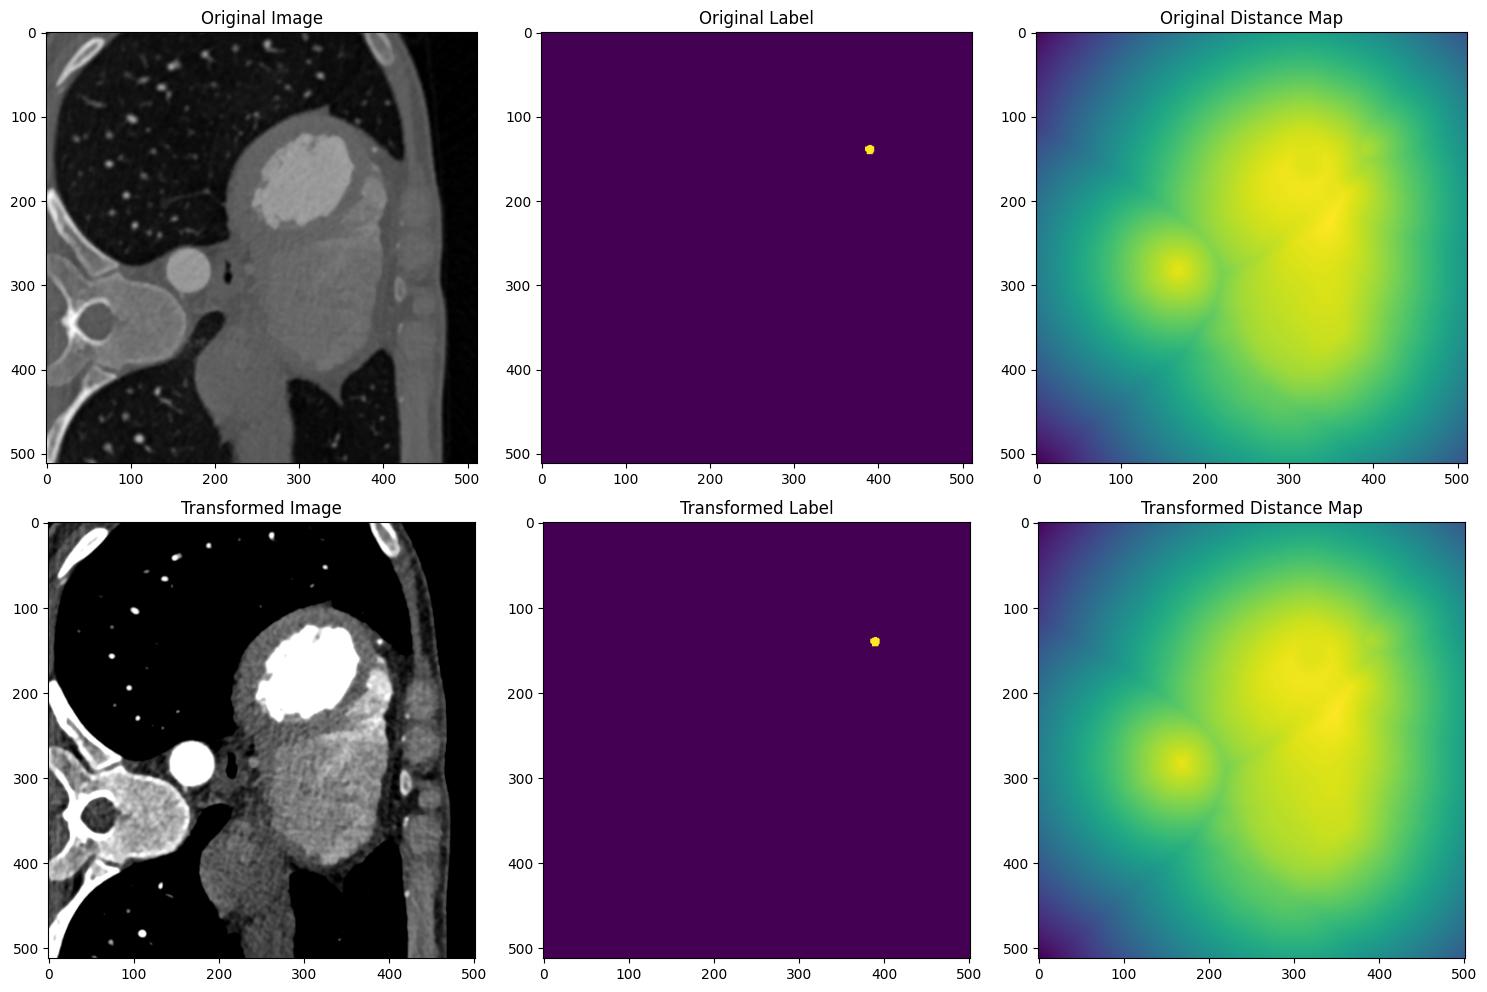


Analyze Distance Map Result:
Shape: torch.Size([1, 8, 512, 501, 275])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
------------------------------------------------------------
   0     | -276.0580  |  82.7345   |  -69.2250  |  61.8576  
   1     |  -2.8284   |  329.1595  |  115.2145  |  58.5534  
   2     |  -32.4962  |  384.6310  |  143.4577  |  71.9734  
   3     |  -15.6205  |  335.6665  |  116.7874  |  69.0712  
   4     |  -62.8729  |  360.1028  |  133.4326  |  73.3065  
   5     |  -52.0192  |  386.0117  |  129.4066  |  84.1378  
   6     |  -37.5366  |  397.0730  |  164.7632  |  72.6675  
   7     |  -41.6293  |  424.7964  |  173.2838  |  92.7978  
------------------------------------------------------------


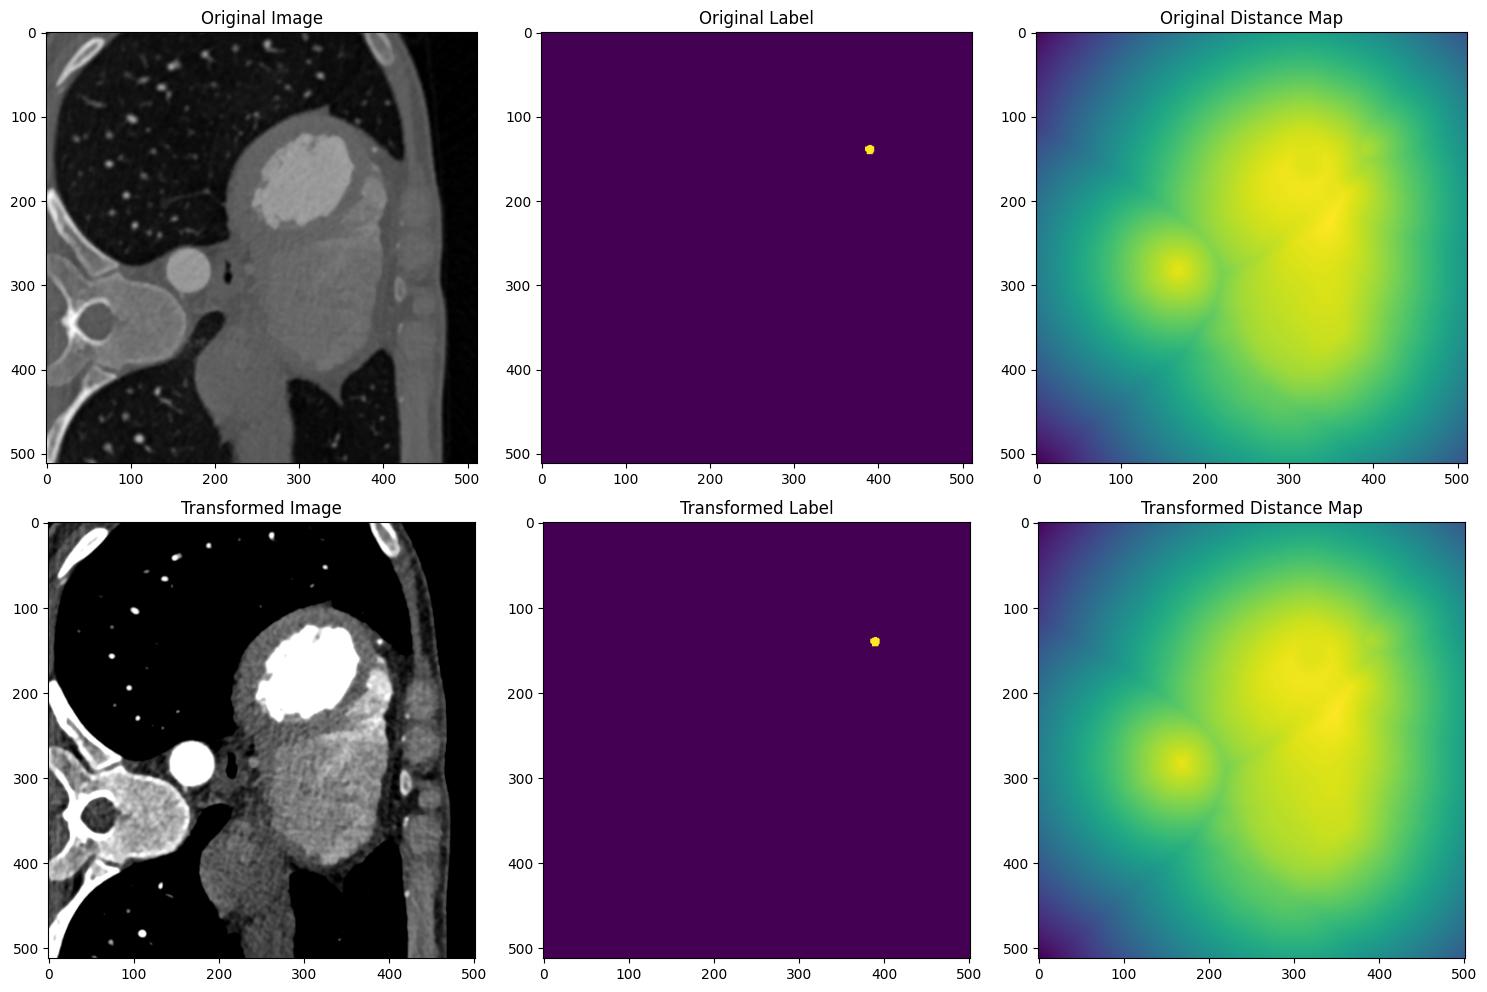


Analyze Distance Map Result:
Shape: torch.Size([1, 8, 512, 501, 275])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
------------------------------------------------------------
   0     |  -1.0000   |   1.0000   |   0.1529   |   0.3448  
   1     |  -1.0000   |   1.0000   |  -0.2889   |   0.3527  
   2     |  -1.0000   |   1.0000   |  -0.1564   |   0.3451  
   3     |  -1.0000   |   1.0000   |  -0.2462   |   0.3932  
   4     |  -1.0000   |   1.0000   |  -0.0718   |   0.3466  
   5     |  -1.0000   |   1.0000   |  -0.1716   |   0.3842  
   6     |  -1.0000   |   1.0000   |  -0.0691   |   0.3344  
   7     |  -1.0000   |   1.0000   |  -0.0785   |   0.3979  
------------------------------------------------------------


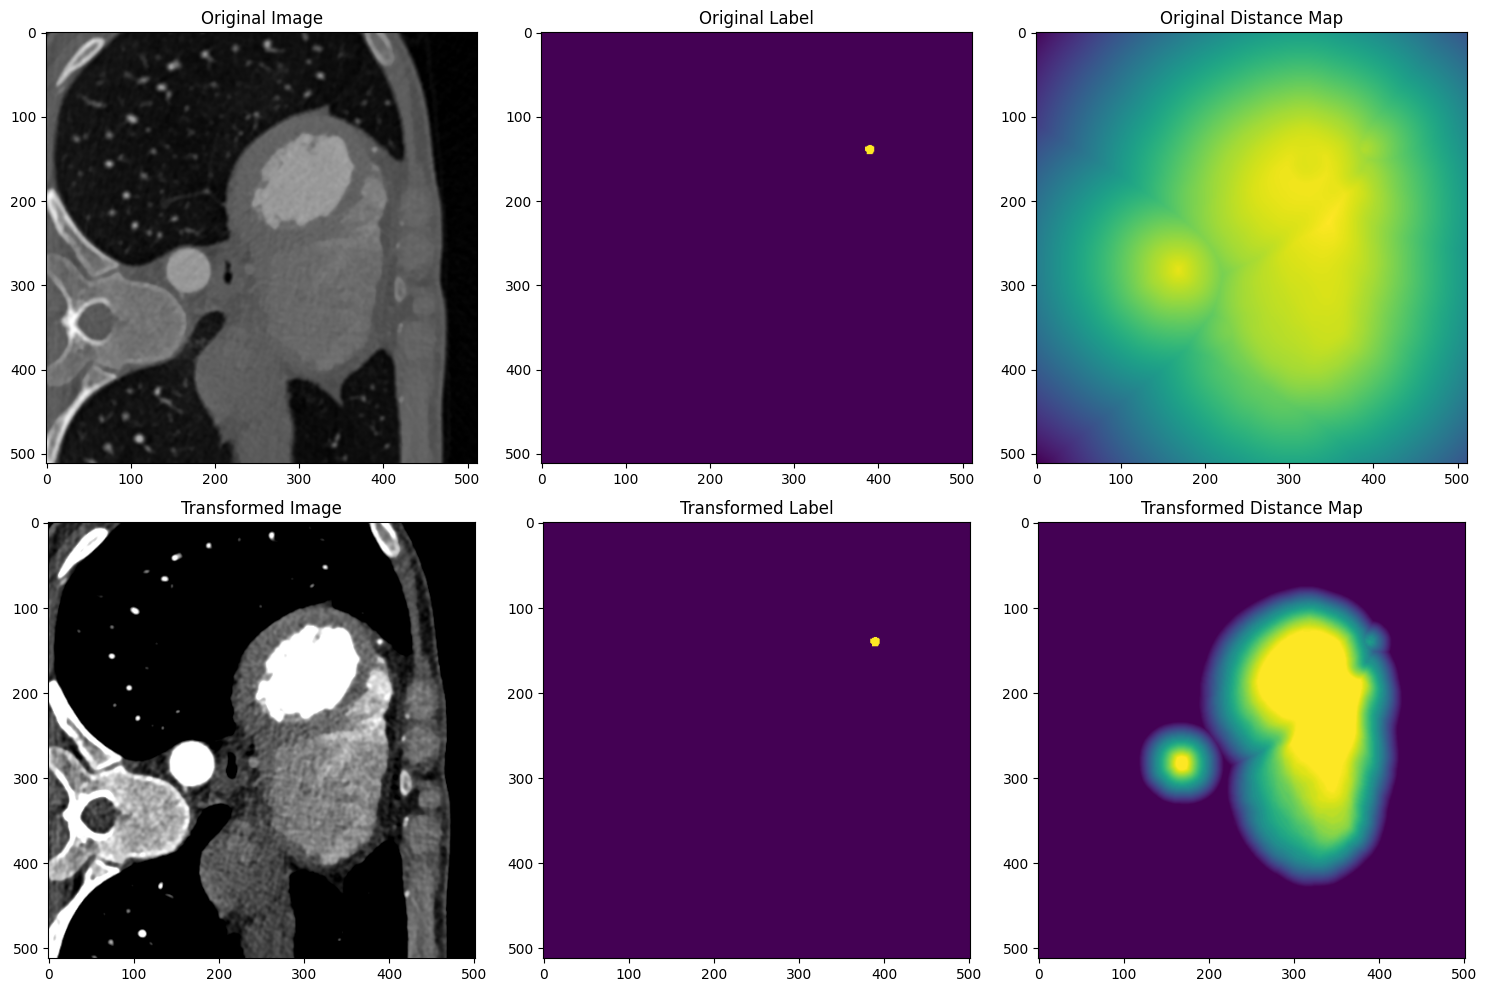


Analyze Distance Map Result:
Shape: torch.Size([1, 8, 512, 501, 275])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
------------------------------------------------------------
   0     |  -1.0000   |   1.0000   |  -0.7131   |   0.6020  
   1     |  -0.1414   |   1.0000   |   0.9898   |   0.0756  
   2     |  -1.0000   |   1.0000   |   0.9692   |   0.1831  
   3     |  -0.7810   |   1.0000   |   0.9402   |   0.2294  
   4     |  -1.0000   |   1.0000   |   0.9356   |   0.2996  
   5     |  -1.0000   |   1.0000   |   0.9184   |   0.3221  
   6     |  -1.0000   |   1.0000   |   0.9752   |   0.1761  
   7     |  -1.0000   |   1.0000   |   0.9683   |   0.1996  
------------------------------------------------------------


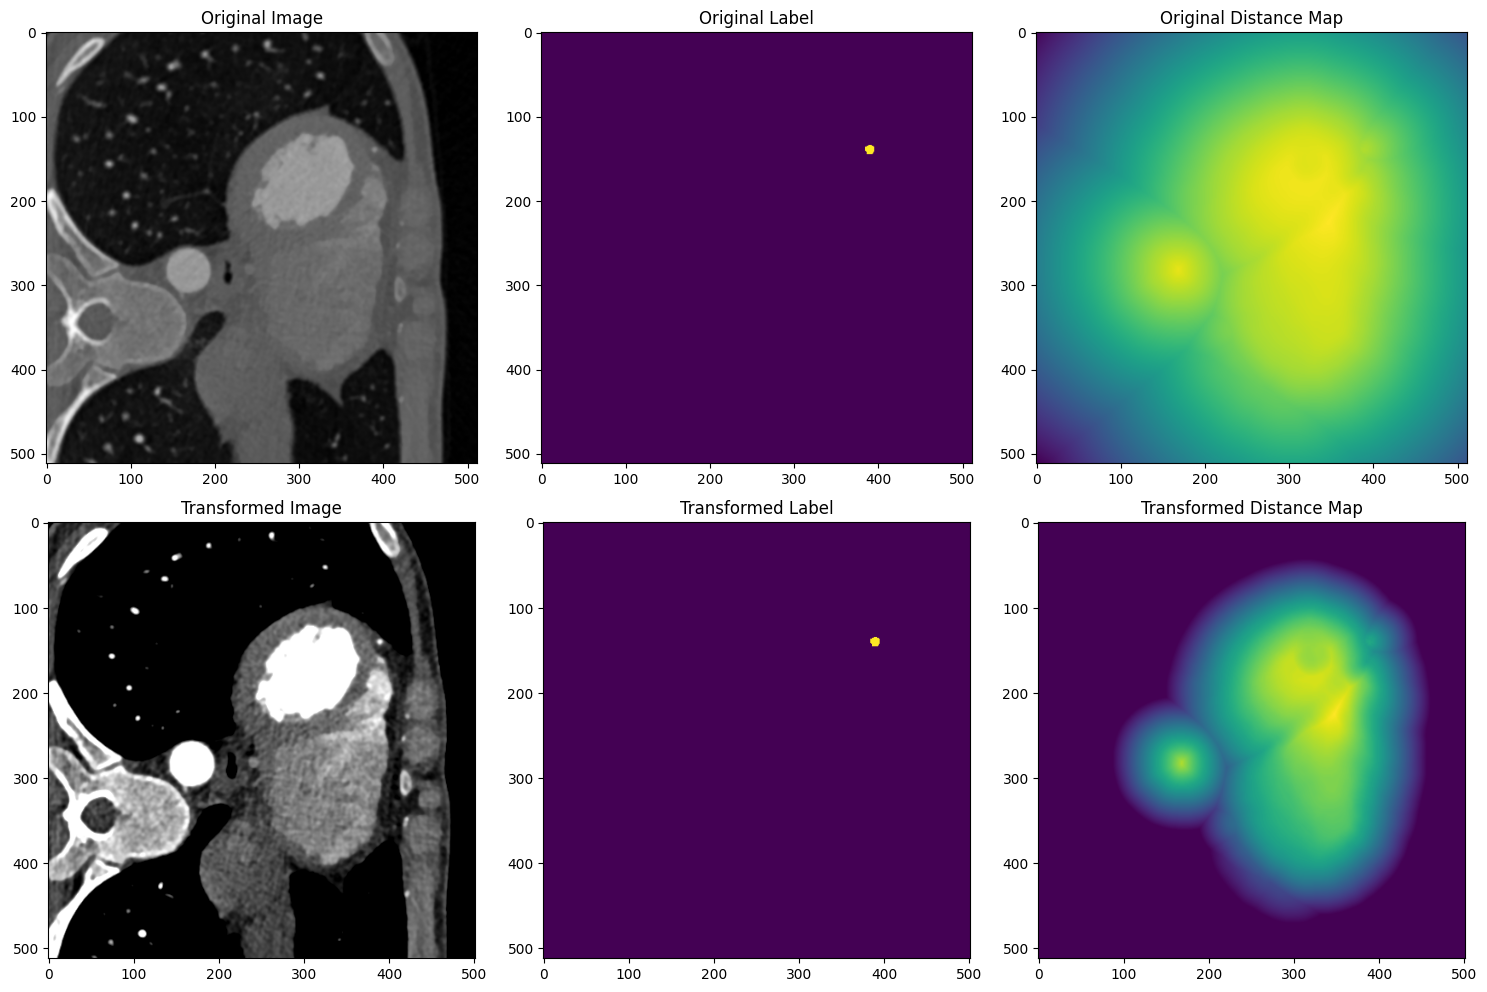


Analyze Distance Map Result:
Shape: torch.Size([1, 8, 512, 501, 275])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
------------------------------------------------------------
   0     |  -1.0000   |   1.0000   |  -0.6741   |   0.5160  
   1     |  -0.0566   |   1.0000   |   0.9515   |   0.1536  
   2     |  -0.6499   |   1.0000   |   0.9436   |   0.1984  
   3     |  -0.3124   |   1.0000   |   0.8920   |   0.2640  
   4     |  -1.0000   |   1.0000   |   0.9126   |   0.2776  
   5     |  -1.0000   |   1.0000   |   0.8855   |   0.3005  
   6     |  -0.7507   |   1.0000   |   0.9607   |   0.1761  
   7     |  -0.8326   |   1.0000   |   0.9496   |   0.1981  
------------------------------------------------------------


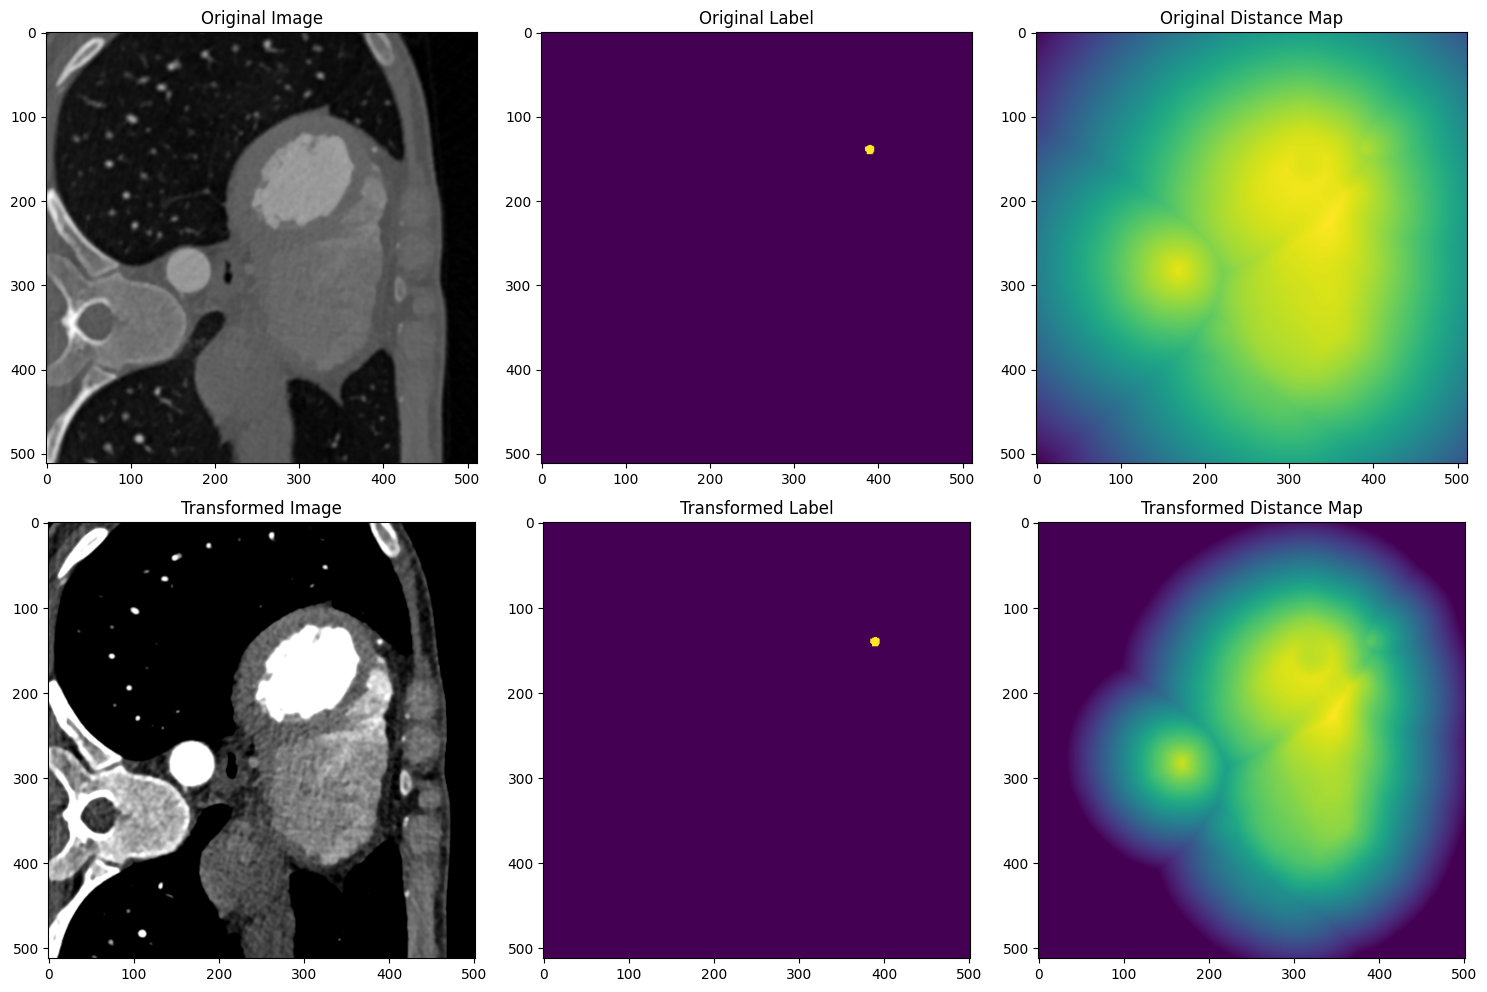


Analyze Distance Map Result:
Shape: torch.Size([1, 8, 512, 501, 275])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
------------------------------------------------------------
   0     |  -1.0000   |   0.8273   |  -0.5604   |   0.4379  
   1     |  -0.0283   |   1.0000   |   0.8358   |   0.2470  
   2     |  -0.3250   |   1.0000   |   0.8737   |   0.2538  
   3     |  -0.1562   |   1.0000   |   0.7915   |   0.3139  
   4     |  -0.6287   |   1.0000   |   0.8391   |   0.2990  
   5     |  -0.5202   |   1.0000   |   0.7938   |   0.3249  
   6     |  -0.3754   |   1.0000   |   0.9164   |   0.2181  
   7     |  -0.4163   |   1.0000   |   0.8929   |   0.2423  
------------------------------------------------------------


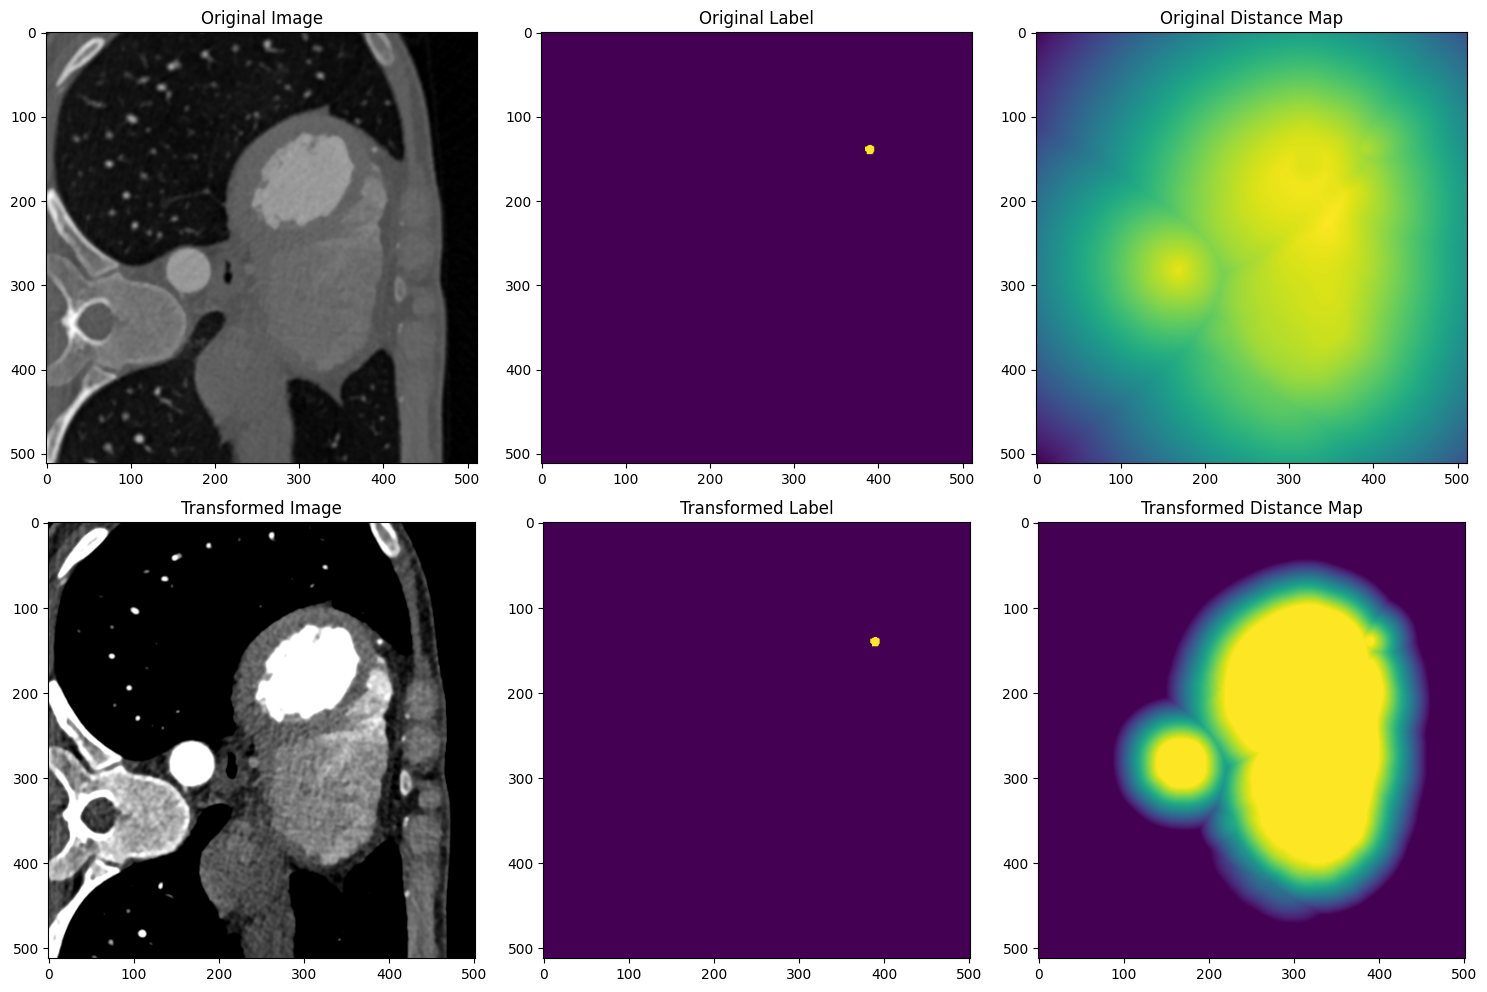


Analyze Distance Map Result:
Shape: torch.Size([1, 8, 512, 501, 275])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
------------------------------------------------------------
   0     |  -1.0000   |   0.0000   |  -0.7293   |   0.3923  
   1     |  -0.0566   |   0.0000   |  -0.0000   |   0.0003  
   2     |  -0.6499   |   0.0000   |  -0.0021   |   0.0234  
   3     |  -0.3124   |   0.0000   |  -0.0020   |   0.0157  
   4     |  -1.0000   |   0.0000   |  -0.0101   |   0.0734  
   5     |  -1.0000   |   0.0000   |  -0.0097   |   0.0634  
   6     |  -0.7507   |   0.0000   |  -0.0025   |   0.0296  
   7     |  -0.8326   |   0.0000   |  -0.0033   |   0.0345  
------------------------------------------------------------


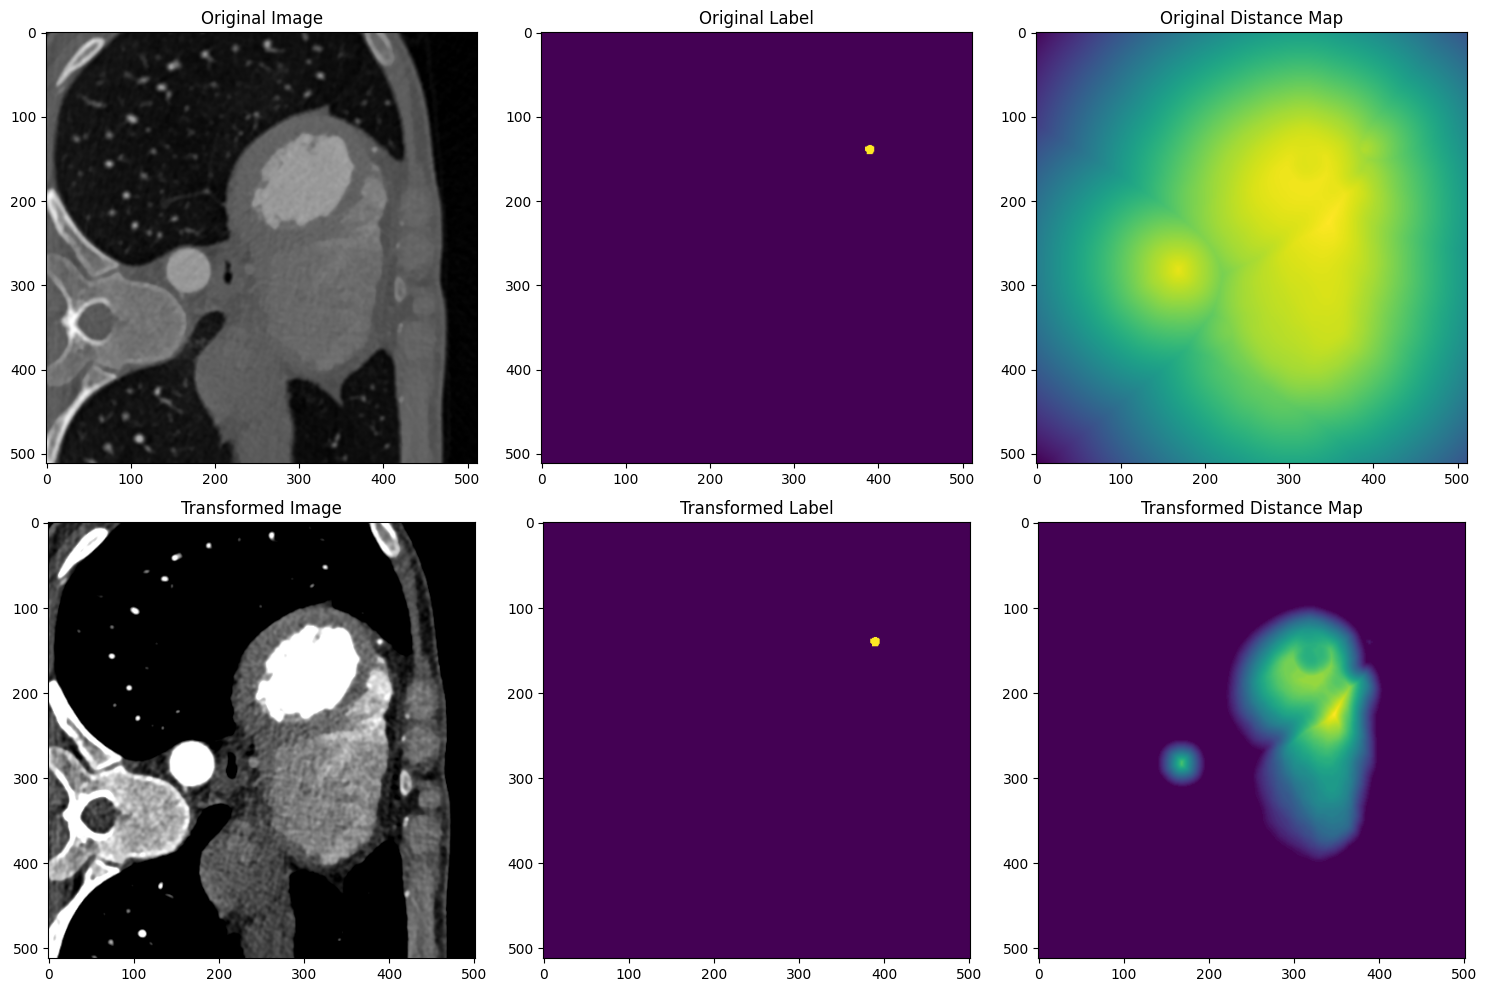


Analyze Distance Map Result:
Shape: torch.Size([1, 8, 512, 501, 275])
------------------------------------------------------------
Channel  |    Min     |    Max     |    Mean    |    Std    
------------------------------------------------------------
   0     |   0.0000   |   0.5516   |   0.0191   |   0.0635  
   1     |   0.0000   |   1.0000   |   0.6932   |   0.2796  
   2     |   0.0000   |   1.0000   |   0.7804   |   0.2882  
   3     |   0.0000   |   1.0000   |   0.6772   |   0.3274  
   4     |   0.0000   |   1.0000   |   0.7425   |   0.3093  
   5     |   0.0000   |   1.0000   |   0.6919   |   0.3312  
   6     |   0.0000   |   1.0000   |   0.8473   |   0.2552  
   7     |   0.0000   |   1.0000   |   0.8162   |   0.2775  
------------------------------------------------------------


In [ ]:
case_dir = "data/imageCAS_ablation/test/790"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")
dist_path = os.path.join(case_dir, "distance_map.nii.gz")

# 1. clipping x, 정규화 x (원본 데이터 그대로)
visualize_transforms(image_path, label_path, dist_path, slice_idx=80, transform=val_transforms_1)
# 2. clipping x, 정규화 -1 ~ 1 (전체 범위를 -1~1로 정규화)
visualize_transforms(image_path, label_path, dist_path, slice_idx=80, transform=val_transforms_2)
# 3. clipping -20 ~ 20, 정규화 -1~1
visualize_transforms(image_path, label_path, dist_path, slice_idx=80, transform=val_transforms_3)
# 4. clipping -50 ~ 50, 정규화 -1 ~ 1
visualize_transforms(image_path, label_path, dist_path, slice_idx=80, transform=val_transforms_4)
# 5. clipping -100 ~ 100, 정규화 -1 ~ 1
visualize_transforms(image_path, label_path, dist_path, slice_idx=80, transform=val_transforms_5)
# 6. clipping -50 ~ 0, 정규화 -1 ~ 0
visualize_transforms(image_path, label_path, dist_path, slice_idx=80, transform=val_transforms_6)
# 7. clipping 0 ~ 150, 정규화 0 ~ 1
visualize_transforms(image_path, label_path, dist_path, slice_idx=80, transform=val_transforms_7)

### 3D Visualization

In [219]:
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio

In [280]:
def visualize_all_channels_3d(distance_map, step=4):
    """
    모든 채널의 3D distance map을 하나의 그래프에 시각화합니다.
    Distance 값에 따라 색상이 변화합니다 (-0.5: 파랑 -> 0: 초록 -> 0.5: 빨강)
    """
    
    # 브라우저에서 열도록 설정
    pio.renderers.default = "browser"
    
    # 전체 데이터 shape 출력
    print("Distance Map Shape:", distance_map.shape)
    
    # 커스텀 컬러스케일 정의 (-0.5 ~ 0.5 범위에 대해)
    custom_colorscale = [
        [0.0, 'red'],       # -0.5
        [0.25, 'orange'],     # -0.25
        [0.5, 'yellow'],     # 0
        [0.75, 'green'],    # 0.25
        [1.0, 'blue']         # 0.5
    ]
    
    # 3D scatter plot 생성
    fig = go.Figure()
    
    for channel in range(distance_map.shape[0]):
        # 현재 채널의 데이터 추출
        channel_data = distance_map[channel].numpy()
        
        # 각 축의 좌표값 생성
        x_coords = range(channel_data.shape[0])
        y_coords = range(channel_data.shape[1])
        z_coords = range(channel_data.shape[2])
        
        # meshgrid로 3D 좌표 생성
        X, Y, Z = np.meshgrid(x_coords[::step], y_coords[::step], z_coords[::step], indexing='ij')
        
        # distance 값 추출
        distances = channel_data[::step, ::step, ::step]
        
        # 마스크 생성 (threshold 값 이하인 점들만 표시)
        mask = np.abs(distances) < 0.5
        
        # 현재 채널의 scatter plot 추가
        fig.add_trace(
            go.Scatter3d(
                x=X[mask],
                y=Y[mask],
                z=Z[mask],
                mode='markers',
                showlegend=False,
                marker=dict(
                    size=2,
                    color=distances[mask],
                    colorscale=custom_colorscale,
                    cmin=-0.5,  # 색상 범위 최소값을 -0.5로 설정
                    cmax=0.5,   # 색상 범위 최대값을 0.5로 설정
                    colorbar=dict(
                        title=dict(
                            text='Distance',
                            side='right'
                        )
                    ),
                    opacity=0.2
                )
            )
        )
        
        print(f"Channel {channel} points:", np.sum(mask))
    
    # 레이아웃 설정 (이전과 동일)
    fig.update_layout(
        title='Distance Map 3D Visualization - All Channels',
        scene=dict(
            xaxis=dict(
                showbackground=False,
                showgrid=False,
                zeroline=False,
                showline=False,
                showticklabels=False,
                showaxeslabels=False,
                title=''
            ),
            yaxis=dict(
                showbackground=False,
                showgrid=False,
                zeroline=False,
                showline=False,
                showticklabels=False,
                showaxeslabels=False,
                title=''
            ),
            zaxis=dict(
                showbackground=False,
                showgrid=False,
                zeroline=False,
                showline=False,
                showticklabels=False,
                showaxeslabels=False,
                title=''
            ),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.2)
            ),
            aspectmode='data',
            bgcolor='rgba(0,0,0,0)'
        ),
        width=1200,
        height=1000,
        showlegend=False,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    
    fig.show()

In [239]:
def create_distance_map(binary_mask):
    distance_maps = []
    
    for c in range(binary_mask.shape[0]):  # each channel
        channel_mask = binary_mask[c].numpy()  # [H, W, D]
        
        # convert to SimpleITK image
        sitk_mask = sitk.GetImageFromArray(channel_mask)
        sitk_mask = sitk.Cast(sitk_mask, sitk.sitkUInt8)
        
        # create distance map
        distance_map = sitk.SignedMaurerDistanceMap(
            sitk_mask,
            insideIsPositive=False,  # heart outside is positive
            squaredDistance=False,
            useImageSpacing=True     # physical distance (mm)
        )
        
        # convert to tensor
        distance_map_array = sitk.GetArrayFromImage(distance_map)
        distance_map_tensor = torch.from_numpy(distance_map_array)
        
        # clip values between -30 and 30
        distance_map_tensor = torch.clamp(distance_map_tensor, min=-clip_value, max=clip_value)
        
        # normalize to [-1, 1] range
        distance_map_tensor = distance_map_tensor / clip_value
        
        distance_maps.append(distance_map_tensor)
    
    return torch.stack(distance_maps)

def ConvertDistanceMap(data):
    seg = data["seg"]  # [C, H, W, D] one-hot encoded segmentation
    
    distance_map = create_distance_map(seg)

    data["seg"] = distance_map
    return data

In [240]:
transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map 
if use_distance_map:
    transforms.append(Lambda(ConvertDistanceMap))

transforms.extend([
    RandCropByPosNegLabeld(
        keys=["image", "label", "seg"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[0],
        prob=0.10,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[1],
        prob=0.10,
    ),
])

if not use_distance_map:
    transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

transforms.append(RandShiftIntensityd(keys="image", offsets=0.05, prob=0.5))

val_transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map
if use_distance_map:
    val_transforms.append(Lambda(ConvertDistanceMap))

if not use_distance_map:
    val_transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

val_transforms = Compose(val_transforms)

train_transforms = Compose(transforms)
val_transforms = Compose(val_transforms)

c:\SEOA\virtual\coronary-artery\.venv\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning:

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.



In [241]:
case_dir = "data/imageCAS/test/790"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")
seg_path = os.path.join(case_dir, "heart_combined.nii.gz")

data_dict = [{"image": image_path, "label": label_path, "seg": seg_path}]
    
basic_transforms = Compose([
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
])
    
basic_ds = Dataset(data=data_dict, transform=basic_transforms)
full_ds = Dataset(data=data_dict, transform=val_transforms)
    
basic_data = first(DataLoader(basic_ds, batch_size=1))
full_data = first(DataLoader(full_ds, batch_size=1))

In [281]:
full_data["seg"] = full_data["seg"].squeeze(0)
visualize_all_channels_3d(full_data["seg"])

Distance Map Shape: torch.Size([8, 512, 501, 275])
Channel 0 points: 158315
Channel 1 points: 17823
Channel 2 points: 33237
Channel 3 points: 76926
Channel 4 points: 42968
Channel 5 points: 65037
Channel 6 points: 22250
Channel 7 points: 27820


In [248]:
def save_distance_map_as_nifti(distance_map, save_folder, reference_path, filename_prefix="distance_map"):
    """
    Distance map을 NIfTI 파일로 저장합니다.
    
    Args:
        distance_map: shape [C, H, W, D]의 distance map tensor
        save_folder: 저장할 폴더 경로
        reference_path: 원본 이미지 경로 (메타 정보를 가져올 NIfTI 파일)
        filename_prefix: 저장할 파일 이름 접두사
    """
    # 저장 폴더 생성
    os.makedirs(save_folder, exist_ok=True)
    
    # 원본 이미지에서 메타 정보 가져오기
    ref_img = nib.load(reference_path)
    affine = ref_img.affine
    header = ref_img.header.copy()
    
    # numpy array로 변환
    distance_map_np = distance_map.detach().cpu().numpy()
    
    # 채널별로 저장
    for c in range(distance_map_np.shape[0]):
        # 현재 채널의 distance map
        channel_map = distance_map_np[c]
        
        # NIfTI 이미지 생성 (원본 affine matrix와 header 사용)
        nifti_img = nib.Nifti1Image(channel_map, affine, header)
        
        # 데이터 타입 설정 (float32로 통일)
        nifti_img.set_data_dtype(np.float32)
        
        # 추가 메타데이터 설정
        header = nifti_img.header
        header['descrip'] = f'Distance Map Channel {c}'  # 설명 추가
        
        # 파일 저장
        output_path = os.path.join(save_folder, f"{filename_prefix}_channel_{c}.nii.gz")
        nib.save(nifti_img, output_path)
        print(f"Saved channel {c} to: {output_path}")
        print(f"Using affine matrix:\n{affine}")
        print(f"Pixel dimensions: {header.get_zooms()}")

# 사용 예시:
save_folder = "./output/distance_maps"
image_path = "./data/imageCAS/test/790/img.nii.gz"
save_distance_map_as_nifti(
    distance_map=full_data["seg"],
    save_folder=save_folder,
    reference_path=image_path,  # 원본 이미지 경로
    filename_prefix="distance_map"
)

Saved channel 0 to: ./output/distance_maps\distance_map_channel_0.nii.gz
Using affine matrix:
[[0.34999999 0.         0.         0.        ]
 [0.         0.34999999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         1.        ]]
Pixel dimensions: (0.35, 0.35, 0.5)
Saved channel 1 to: ./output/distance_maps\distance_map_channel_1.nii.gz
Using affine matrix:
[[0.34999999 0.         0.         0.        ]
 [0.         0.34999999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         1.        ]]
Pixel dimensions: (0.35, 0.35, 0.5)
Saved channel 2 to: ./output/distance_maps\distance_map_channel_2.nii.gz
Using affine matrix:
[[0.34999999 0.         0.         0.        ]
 [0.         0.34999999 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         1.        ]]
Pixel dimensions: (0.35, 0.35, 0.5)
Saved channel 3 to: ./output/distance_maps\

## Transforms in Proposed Dataloader with MONAI

In [104]:
import autorootcwd
import monai
from monai.utils import first, set_determinism
from monai.transforms import (
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandFlipd,
    CropForegroundd,
    Compose,
    Spacingd,
    AsDiscreted,
    GaussianSmoothd,
    Lambda,
    DistanceTransformEDTd, DistanceTransformEDT,
    ToTensord,
)
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import SimpleITK as sitk
import os
import torch
import numpy as np
import pytorch_lightning as pl
from pathlib import Path
import matplotlib.pyplot as plt
import cucim

print(cucim.__version__)
from monai.transforms import DistanceTransformEDTd
print(DistanceTransformEDTd.__module__)
print(DistanceTransformEDTd.__doc__)

23.10.00
monai.transforms.post.dictionary

    Applies the Euclidean distance transform on the input.
    Either GPU based with CuPy / cuCIM or CPU based with scipy.
    To use the GPU implementation, make sure cuCIM is available and that the data is a `torch.tensor` on a GPU device.

    Note that the results of the libraries can differ, so stick to one if possible.
    For details, check out the `SciPy`_ and `cuCIM`_ documentation and / or :func:`monai.transforms.utils.distance_transform_edt`.


    Note on the input shape:
        Has to be a channel first array, must have shape: (num_channels, H, W [,D]).
        Can be of any type but will be converted into binary: 1 wherever image equates to True, 0 elsewhere.
        Input gets passed channel-wise to the distance-transform, thus results from this function will differ
        from directly calling ``distance_transform_edt()`` in CuPy or SciPy.

    Args:
        keys: keys of the corresponding items to be transformed.
        all

In [106]:
use_distance_map = True

In [ ]:
transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map 
if use_distance_map:
    transforms.append(
        DistanceTransformEDTd(keys=["seg"])
    )

transforms.extend([
    RandCropByPosNegLabeld(
        keys=["image", "label", "seg"],
        label_key="label",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[0],
        prob=0.10,
    ),
    RandFlipd(
        keys=["image", "label", "seg"],
        spatial_axis=[1],
        prob=0.10,
    ),
])

if not use_distance_map:
    transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

transforms.append(RandShiftIntensityd(keys="image", offsets=0.05, prob=0.5))

val_transforms = [
    LoadImaged(keys=["image", "label", "seg"]),
    EnsureChannelFirstd(keys=["image", "label", "seg"]),
    Orientationd(keys=["image", "label", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-150,
        a_max=550,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    AsDiscreted(
        keys=["seg"],
        to_onehot=8,
    ),
    CropForegroundd(keys=["image", "label", "seg"], source_key="image"),
]

# distance map
if use_distance_map:
    val_transforms.append(DistanceTransformEDTd(keys=["seg"]))

if not use_distance_map:
    val_transforms.append(GaussianSmoothd(keys=["seg"], sigma=1.0))

val_transforms = Compose(val_transforms)

train_transforms = Compose(transforms)
val_transforms = Compose(val_transforms)

In [66]:
def visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=train_transforms):
    """visualize the before/after transforms for a specific image."""
    
    data_dict = [{"image": image_path, "label": label_path, "seg": seg_path}]
    
    basic_transforms = Compose([
        LoadImaged(keys=["image", "label", "seg"]),
        EnsureChannelFirstd(keys=["image", "label", "seg"]),
    ])
    
    basic_ds = Dataset(data=data_dict, transform=basic_transforms)
    full_ds = Dataset(data=data_dict, transform=transform)
    
    basic_data = first(DataLoader(basic_ds, batch_size=1))
    full_data = first(DataLoader(full_ds, batch_size=1))
    
    # === 여기서 device 정보 출력 ===
    print("Transformed seg device:", full_data["seg"].device)
    print("Transformed image device:", full_data["image"].device)
    # =============================
    
    plt.figure("Transforms Visualization", (15, 10))
    
    # Original Data (First Row)
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(basic_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    plt.subplot(2, 3, 2)
    plt.title("Original Label")
    plt.imshow(basic_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 3, 3)
    plt.title("Original Segmentation")
    plt.imshow(basic_data["seg"][0, 0, :, :, slice_idx])
    
    # Transformed Data (Second Row)
    plt.subplot(2, 3, 4)
    plt.title("Transformed Image")
    plt.imshow(full_data["image"][0, 0, :, :, slice_idx], cmap="gray")
    
    plt.subplot(2, 3, 5)
    plt.title("Transformed Label")
    plt.imshow(full_data["label"][0, 0, :, :, slice_idx])

    plt.subplot(2, 3, 6)
    plt.title("Transformed Segmentation")
    plt.imshow(full_data["seg"][0, 0, :, :, slice_idx].cpu())
    # if full_data["seg"].shape[1] > 1:  # if one-hot encoded or distance map
    #     # Combine all channels for visualization
    #     seg_vis = np.sum(full_data["seg"][0, :, :, :, slice_idx], axis=0)
    #     plt.imshow(seg_vis)
    # else:
    #     plt.imshow(full_data["seg"][0, 0, :, :, slice_idx])
    
    plt.tight_layout()
    plt.show()
   

Transformed seg device: cuda:0
Transformed image device: cpu


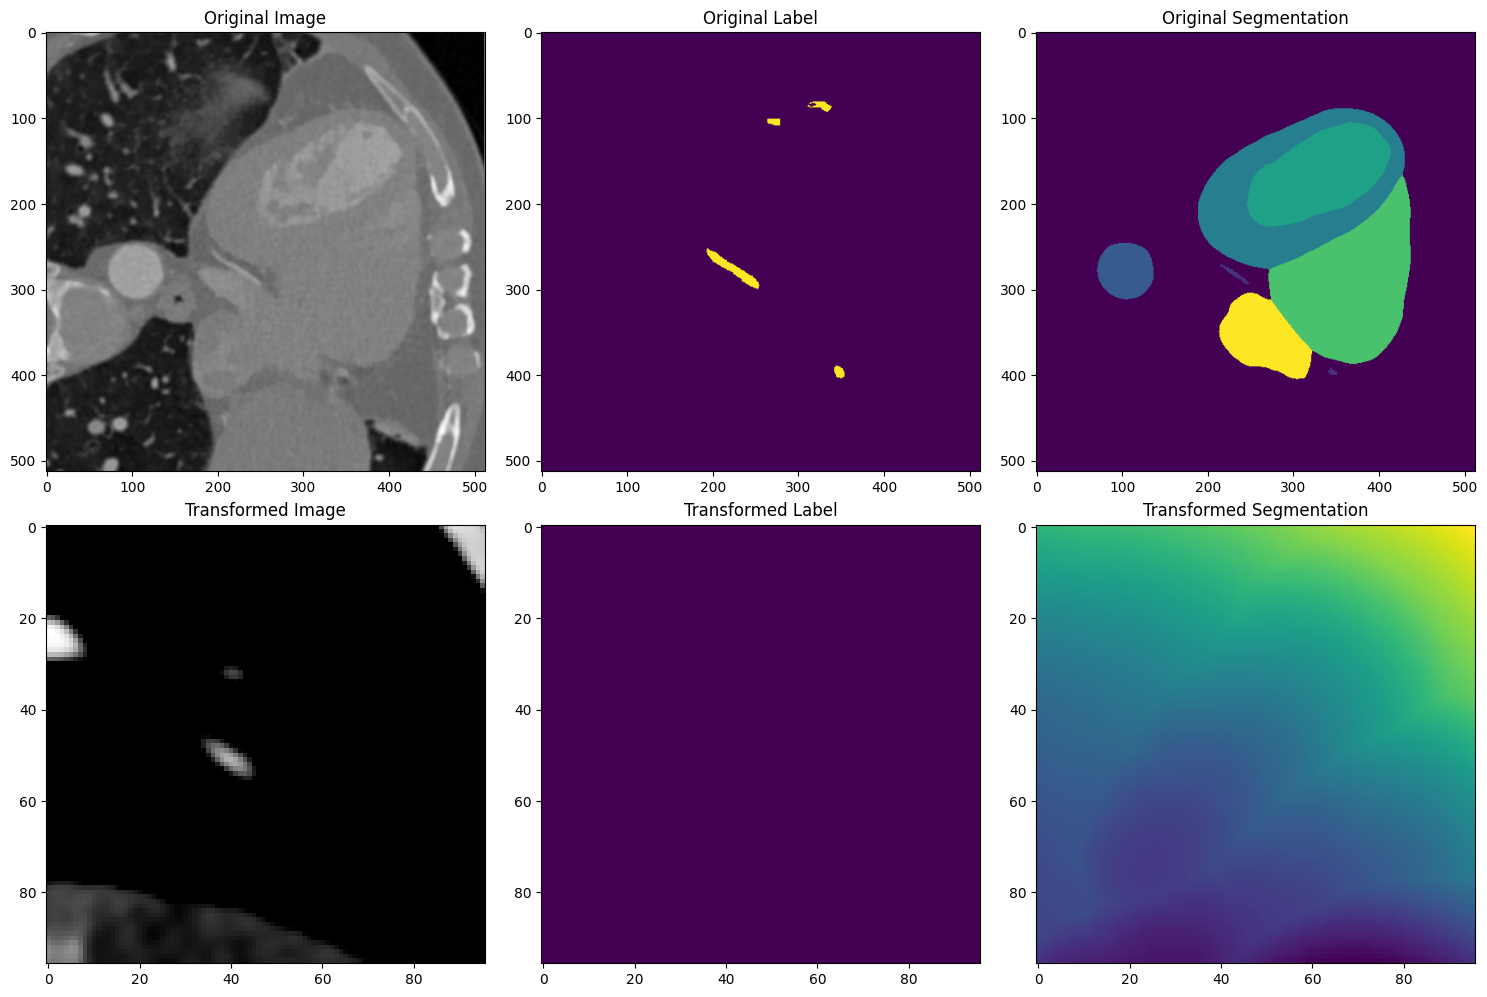

In [67]:
case_dir = "data/imageCAS_heart/test/1000"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")
seg_path = os.path.join(case_dir, "heart_combined.nii.gz")

visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=train_transforms)

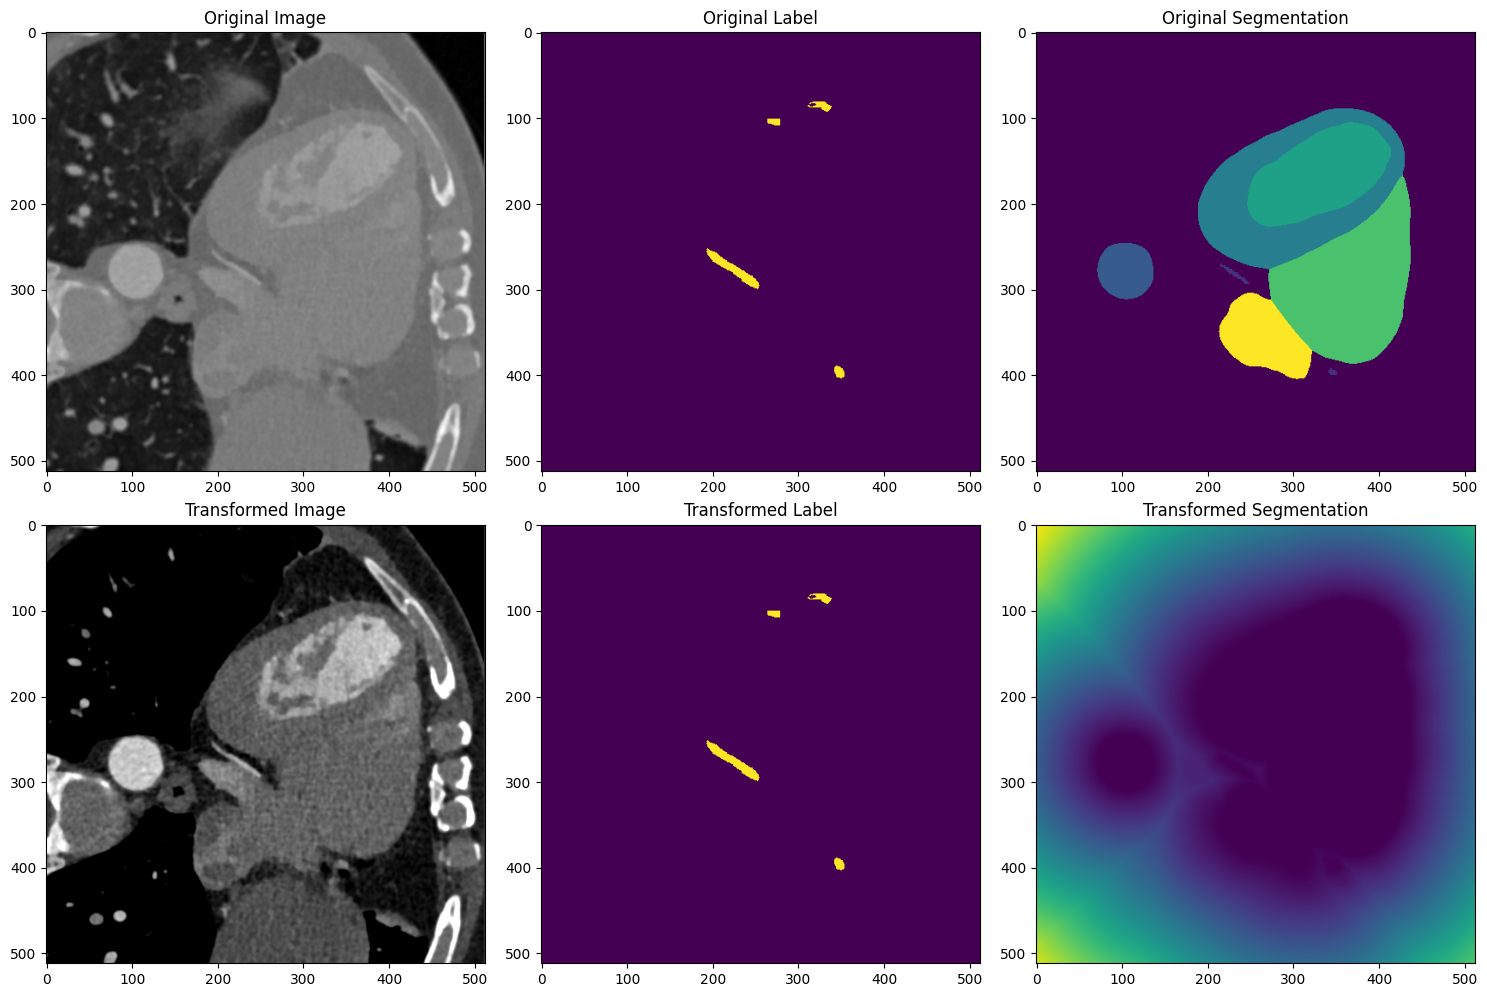

In [24]:
case_dir = "data/imageCAS_heart/test/1000"
image_path = os.path.join(case_dir, "img.nii.gz")
label_path = os.path.join(case_dir, "label.nii.gz")
seg_path = os.path.join(case_dir, "heart_combined.nii.gz")

visualize_transforms(image_path, label_path, seg_path, slice_idx=80, transform=val_transforms)

In [216]:
import time
import torch

# 예시: [C, H, W, D] shape의 one-hot mask
mask = torch.randint(0, 2, (8, 256, 256, 256)).float()

from monai.transforms import DistanceTransformEDT

distance_transform = DistanceTransformEDT()

# CPU에서 시간 측정
start = time.time()
result_cpu = distance_transform(mask)
print("CPU time:", time.time() - start)

# GPU에서 시간 측정
mask_cuda = mask.cuda()
torch.cuda.synchronize()
start = time.time()
result_gpu = distance_transform(mask_cuda)
torch.cuda.synchronize()
print("GPU time:", time.time() - start)

KeyboardInterrupt: 